# mRNN 101 with GenCode 25 and Hendrix-like prep

In [1]:
#from google.colab import drive
#PATH='/content/drive/'
#drive.mount(PATH)
#DATAPATH=PATH+'My Drive/data/'
#PC_FILENAME = DATAPATH+'pcRNA.fasta'
#NC_FILENAME = DATAPATH+'ncRNA.fasta'
# LOCAL
PCT_FILENAME = 'hdx.train.pcRNA.oneline.fasta'
NCT_FILENAME = 'hdx.train.ncRNA.oneline.fasta'
PCV_FILENAME = 'hdx.valid.pcRNA.oneline.fasta'
NCV_FILENAME = 'hdx.valid.ncRNA.oneline.fasta'

In [2]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import time

tf.keras.backend.set_floatx('float32')

EPOCHS=100
SPLITS=1
K=1
EMBED_DIMEN=16
FILENAME='HDX101'

## Load and partition sequences

In [3]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [4]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [5]:
def build_model(maxlen,dimen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    neurons=16
    rnn = keras.models.Sequential()
    embed_layer = keras.layers.Embedding(
        vocabulary_size,EMBED_DIMEN,input_length=maxlen);
    rnn1_layer = keras.layers.Bidirectional(
        keras.layers.GRU(neurons, return_sequences=True, dropout=0.50, 
            input_shape=[maxlen,dimen]))
    rnn2_layer = keras.layers.Bidirectional(
        keras.layers.GRU(neurons, dropout=0.50, return_sequences=True))
    dense1_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    dense2_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [6]:
def train_and_validate(X,y,Xvalid,yvalid,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    rnn2=None
    X_train=X
    y_train=y
    X_valid=Xvalid
    y_valid=yvalid

    print("BUILD MODEL")
    rnn2=build_model(maxlen,dimen)

    print("FIT")
    # this is complaining about string to float
    start_time=time.time()
    history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
            validation_data=(X_valid,y_valid) )
    end_time=time.time()
    elapsed_time=(end_time-start_time)

    fold += 1
    print("Fold %d, %d epochs, %d sec"%(fold,eps,elapsed_time))

    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

    scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
    print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
    # What are the other metrics_names?
    # Try this from Geron page 505:
    # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
    cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return rnn2

In [7]:
def make_kmers(MINLEN,MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [8]:
print("Load data from files.")
nct_seq=load_fasta(NCT_FILENAME,0)
pct_seq=load_fasta(PCT_FILENAME,1)
ncv_seq=load_fasta(NCV_FILENAME,0)
pcv_seq=load_fasta(PCV_FILENAME,1)
all_train=pd.concat((nct_seq,pct_seq),axis=0)
all_valid=pd.concat((ncv_seq,pcv_seq),axis=0)
nct_seq=None
pct_seq=None
ncv_seq=None
pcv_seq=None

##print("Put aside the test portion.")
##(train_set,test_set)=make_train_test(all_seq)

print("FASTA LOADED")


Load data from files.
FASTA LOADED


## Len 200-1Kb


Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (32000, 4)
no short (31434, 4)
no long, no short (9474, 4)
original (1000, 4)
no short (978, 4)
no long, no short (140, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(9474, 1)
sequence    GTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCC...
Name: 0, dtype: object
712
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[3 4 3 ... 0 0 0]
 [3 1 1 ... 0 0 0]
 [2 4 3 ... 0 0 0]
 ...
 [2 3 2 ... 0 0 0]
 [1 4 1 ... 0 0 0]
 [1 4 3 ... 0 0 0]]
<class 'pandas.core.frame.DataFrame'>
(140, 1)
sequence    CAAAACAAATAACTGTTAGAAGGTACAATTTTCTTCTCTTCCCTGT...
Name: 18, dtype: object
384
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[2 1 1 ... 0 0 0]
 [1 4 3 ... 0 0 0]
 [2 4 3 ... 0 0 0]
 ...
 [4 3 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [1 3 1 ... 0 0 0]]
Compile the model
COMPILE
Model: "sequential"
_______________________________________________________

Epoch 43/100
297/297 [==============================] - 301s 1s/step - loss: 0.5221 - accuracy: 0.7465 - val_loss: 0.5424 - val_accuracy: 0.6930
Epoch 44/100
297/297 [==============================] - 301s 1s/step - loss: 0.5172 - accuracy: 0.7501 - val_loss: 0.5443 - val_accuracy: 0.6961
Epoch 45/100
297/297 [==============================] - 288s 971ms/step - loss: 0.5172 - accuracy: 0.7495 - val_loss: 0.5423 - val_accuracy: 0.6885
Epoch 46/100
297/297 [==============================] - 291s 978ms/step - loss: 0.5173 - accuracy: 0.7492 - val_loss: 0.5498 - val_accuracy: 0.6999
Epoch 47/100
297/297 [==============================] - 289s 972ms/step - loss: 0.5134 - accuracy: 0.7513 - val_loss: 0.5390 - val_accuracy: 0.6993
Epoch 48/100
297/297 [==============================] - 291s 979ms/step - loss: 0.5117 - accuracy: 0.7541 - val_loss: 0.5302 - val_accuracy: 0.6952
Epoch 49/100
297/297 [==============================] - 288s 969ms/step - loss: 0.5117 - accuracy: 0.7513 - val_loss: 

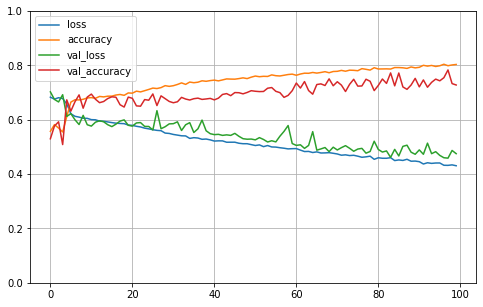

accuracy: 72.77%

Validation core mean 72.77% (+/- 0.00%)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: HDX101.short.model/assets


In [9]:
MINLEN=200
MAXLEN=1000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
train_subset=make_slice(all_train,MINLEN,MAXLEN)# One array to two: X and y
valid_subset=make_slice(all_valid,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,train_subset)
(X_valid,y_valid)=make_kmers(MINLEN,MAXLEN,valid_subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Train and validate")
model1=train_and_validate(X_train,y_train,X_valid,y_valid,EPOCHS,MAXLEN,EMBED_DIMEN)
model1.save(FILENAME+'.short.model')

## Len 1K-2Kb

In [ ]:
MINLEN=1000
MAXLEN=2000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
train_subset=make_slice(all_train,MINLEN,MAXLEN)# One array to two: X and y
valid_subset=make_slice(all_valid,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,train_subset)
(X_valid,y_valid)=make_kmers(MINLEN,MAXLEN,valid_subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Train and validate")
model2=train_and_validate(X_train,y_train,X_valid,y_valid,EPOCHS,MAXLEN,EMBED_DIMEN)
model2.save(FILENAME+'.medium.model')

Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (32000, 4)
no short (4592, 4)
no long, no short (874, 4)
original (1000, 4)
no short (204, 4)
no long, no short (30, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(874, 1)
sequence    CACACAACGGGGTTTCGGGGCTGTGGACCCTGTGCCAGGAAAGGAA...
Name: 2, dtype: object
1187
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[2 1 2 ... 0 0 0]
 [1 3 3 ... 0 0 0]
 [4 3 4 ... 0 0 0]
 ...
 [3 2 1 ... 0 0 0]
 [2 4 4 ... 0 0 0]
 [1 3 2 ... 0 0 0]]
<class 'pandas.core.frame.DataFrame'>
(30, 1)
sequence    GTCGCTCACGAGGTCGCGCCTCGCACCCGCCTTCCTCCTTTTCTTT...
Name: 72, dtype: object
1184
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[3 4 2 ... 0 0 0]
 [2 3 3 ... 0 0 0]
 [3 2 3 ... 0 0 0]
 ...
 [1 1 3 ... 0 0 0]
 [1 4 3 ... 0 0 0]
 [2 3 4 ... 0 0 0]]
Compile the model
COMPILE
Model: "sequential_2"
_______________________________________________________

Epoch 44/100
28/28 [==============================] - 64s 2s/step - loss: 0.6673 - accuracy: 0.5926 - val_loss: 0.7269 - val_accuracy: 0.4492
Epoch 45/100
28/28 [==============================] - 65s 2s/step - loss: 0.6654 - accuracy: 0.5990 - val_loss: 0.7231 - val_accuracy: 0.4712
Epoch 46/100
28/28 [==============================] - 64s 2s/step - loss: 0.6634 - accuracy: 0.6042 - val_loss: 0.7295 - val_accuracy: 0.4474
Epoch 47/100
28/28 [==============================] - 64s 2s/step - loss: 0.6590 - accuracy: 0.6117 - val_loss: 0.7230 - val_accuracy: 0.4721
Epoch 48/100
28/28 [==============================] - 64s 2s/step - loss: 0.6602 - accuracy: 0.6113 - val_loss: 0.7261 - val_accuracy: 0.4543
Epoch 49/100
28/28 [==============================] - 64s 2s/step - loss: 0.6563 - accuracy: 0.6255 - val_loss: 0.7293 - val_accuracy: 0.4530
Epoch 50/100
28/28 [==============================] - 64s 2s/step - loss: 0.6531 - accuracy: 0.6263 - val_loss: 0.7263 - val_accuracy: 0.4440
Epoch 

## Len 2K-3Kb

In [ ]:
MINLEN=2000
MAXLEN=3000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
train_subset=make_slice(all_train,MINLEN,MAXLEN)# One array to two: X and y
valid_subset=make_slice(all_valid,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,train_subset)
(X_valid,y_valid)=make_kmers(MINLEN,MAXLEN,valid_subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Train and validate")
model3=train_and_validate(X_train,y_train,X_valid,y_valid,EPOCHS,MAXLEN,EMBED_DIMEN)
model3.save(FILENAME+'.long.model')

In [ ]:
model1.save(FILENAME+'.short.model')